This tutorial notebook is intended to give you an overview of some mechanics of the game.

# Basics

With a `GameManager` object we can manipulate the game state as we desire.

In [1]:
from core.game import GameManager

In [2]:
?GameManager

Init signature: GameManager()
Docstring:      Utility class that helps in manage the states of the game and build actions.
File:           d:\development\wargames\newtechnowar\code\core\game\manager.py
Type:           type
Subclasses:     


In [3]:
gm = GameManager()

We can build our own `board` and `state` or simply start with an existing one. 

In this case we use a scenario where we have 2 red tanks and 2 blue tanks.

In [4]:
from core.scenarios import buildScenario

In [5]:
?buildScenario

Signature: buildScenario(name: str) -> Tuple[core.game.board.GameBoard, core.game.state.GameState]
Docstring: Build the scenario associated with the given name from the loaded templates.
File:      d:\development\wargames\newtechnowar\code\core\scenarios\functions.py
Type:      function


In [6]:
board, state = buildScenario('Test2v2')

From the state, can we get our figures using the `getFigure()` method from a `GameState` object.

In [7]:
from core.const import RED, BLUE

In [8]:
?state.getFigure

Signature: state.getFigure(action: core.actions.basics.ActionFigure) -> core.figures.figure.Figure
Docstring: Given an action, returns the figure that performs such action.
File:      d:\development\wargames\newtechnowar\code\core\game\state.py
Type:      method


In [9]:
r1, r2 = state.getFigures(RED)
b1, b2 = state.getFigures(BLUE)

As an example, we want to attack `b1` with `r2` using `r2`'s cannon (`CA`).

To do so we build an `atk` of type `Attack` using the method `actionAttackFigure` from the `GameManger` object.

In [10]:
?gm.actionAttackFigure

Signature:
gm.actionAttackFigure(
    board: core.game.board.GameBoard,
    state: core.game.state.GameState,
    figure: core.figures.figure.Figure,
    target: core.figures.figure.Figure,
    weapon: core.figures.weapons.Weapon,
) -> core.actions.attacks.Attack
Docstring:
Creates an Attack action for a figure given the specified target and weapon. Can raise ValueError if the shot
is not doable.
File:      d:\development\wargames\newtechnowar\code\core\game\manager.py
Type:      method


In [11]:
try:
    atk = gm.actionAttackFigure(board, state, r2, b1, r1.weapons['CA'])
except ValueError as e:
    print(e)

Cannon cannot hit Tank3(11, 11) from (3, 3): no LOS on target


...and we cannot do that since we don't have LOS on target. We need to first move `r2` to have a clean LOS on target.

This is the right time to start to _visualize_ the map
 we are playing on.

In [12]:
from utils.images import drawState

In [13]:
?drawState

Signature:
drawState(
    board: core.game.board.GameBoard,
    state: core.game.state.GameState,
    show_last_action: bool = False,
    size: int = None,
) -> <module 'PIL.Image' from 'C:\\Users\\Claudio\\Miniconda3\\envs\\wargames\\lib\\site-packages\\PIL\\Image.py'>
Docstring:
Returns an Image with the board and the current state drawn on it.
Set 'last_action' or 'utils.images.ALWAYS_ACTIONS' to TRUE to also print the action that generated the state (if any).
File:      d:\development\wargames\newtechnowar\code\utils\images.py
Type:      function


In [14]:
import utils.images
utils.images.SIZE = 18

We can globally change the size of the output images (I suggest to use multiples of 6 to avoid artifacts).

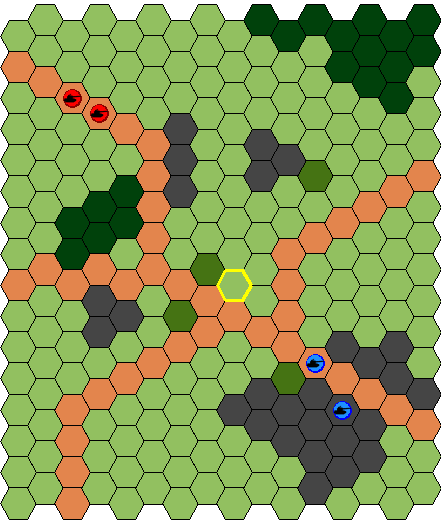

In [15]:
drawState(board, state)

Much more clearer. Let's highlight the position of `r2` and `b1` on the map.

At the same time we draw the LOS from `r2` to `b1`.

In [16]:
from utils.images import drawHexagon, drawLine

In [17]:
?drawHexagon

Signature:
drawHexagon(
    img: <module 'PIL.Image' from 'C:\\Users\\Claudio\\Miniconda3\\envs\\wargames\\lib\\site-packages\\PIL\\Image.py'>,
    pos: Tuple[int, int],
    color: str,
    width: int = 1,
    fill: str = None,
    alpha: int = 255,
    size: int = None,
) -> None
Docstring: Draws an hexagon at the given (x,y) coordinates in hex-space over the given 'img' image.
File:      d:\development\wargames\newtechnowar\code\utils\images.py
Type:      function


In [18]:
?drawLine

Signature:
drawLine(
    img: <module 'PIL.Image' from 'C:\\Users\\Claudio\\Miniconda3\\envs\\wargames\\lib\\site-packages\\PIL\\Image.py'>,
    start: Tuple[int, int],
    end: Tuple[int, int],
    color: str,
    width: int = 1,
    alpha: int = 255,
    size: int = None,
)
Docstring: <no docstring>
File:      d:\development\wargames\newtechnowar\code\utils\images.py
Type:      function


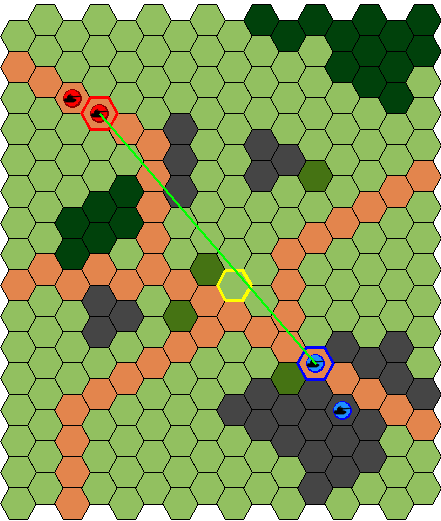

In [19]:
img = drawState(board, state)
r2_pos = r2.position.tuple()
b1_pos = b1.position.tuple()
drawHexagon(img, r2_pos, '#ff0000', width=2)  # red hex
drawHexagon(img, b1_pos, '#0000ff', width=2)  # blue hex
drawLine(img, r2_pos, b1_pos, color='#00ff00', width=2) # green line
img

The LOS between `r2` and `b1` goes through a _dark grey_ hex. This is a blocker for the LOS.

We need to move `r2` in a position that can see `b1` to obtain a valid shoot. `r2` position is:

In [20]:
r2.position

(3, -4, 1)

A triple means that it's current position is expressed in `cube-space`, we want coordinates in `grid-space` since it is much more natural for us. We just need to convert to `tuple`:

In [21]:
r2.position.tuple()

(3, 3)

The game works in cube-space so any position need to be expressed in `Cube`. Fortunately we can use the coordinates utility classes to to convert from `grid-space` (`Hex`) to `cube-space` (`Cube`).

In [22]:
from core.utils.coordinates import Hex

In [23]:
dst = Hex(5,8).cube()
m = gm.actionMove(board, state, r2, destination=dst)
m

red  : Tank2     : Move to (5, 8)

Object `m` is our movement action from `(2,2)` (current position of `r1`) to `(4,4)`.

We can now generate a new state where the tank `r1` changed its position.

In [24]:
new_state, outcome = gm.activate(board, state, m)

Note how `new_state` is not the same as previous `state`.

In [25]:
new_state == state

False

We can check by looking at the images of the states:

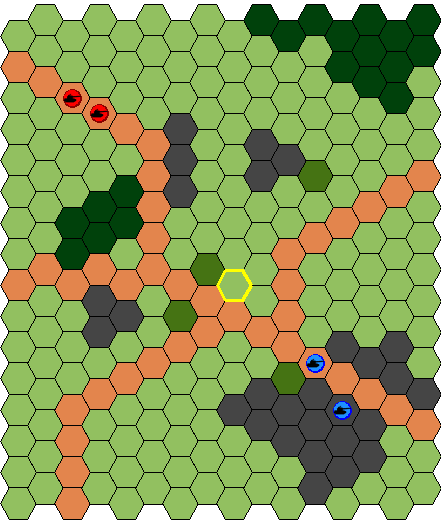

In [26]:
drawState(board, state)

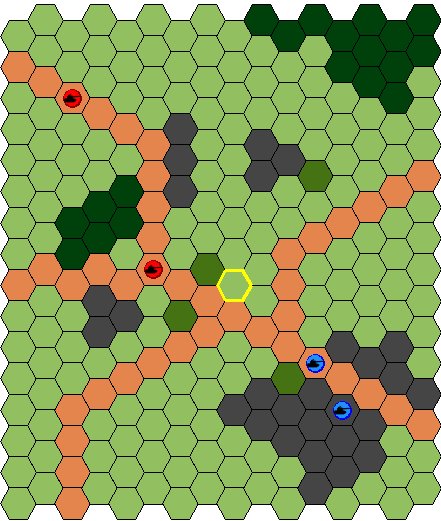

In [27]:
drawState(board, new_state)

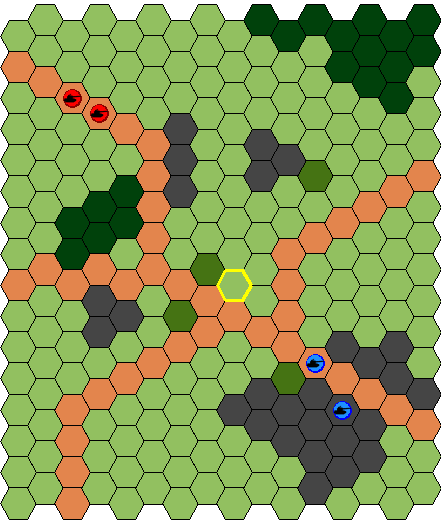

Or we can directly update the original state.

In [28]:
outcome = gm.step(board, state, m)

Now `new_state` and `state` are the same:

In [29]:
new_state == state

True

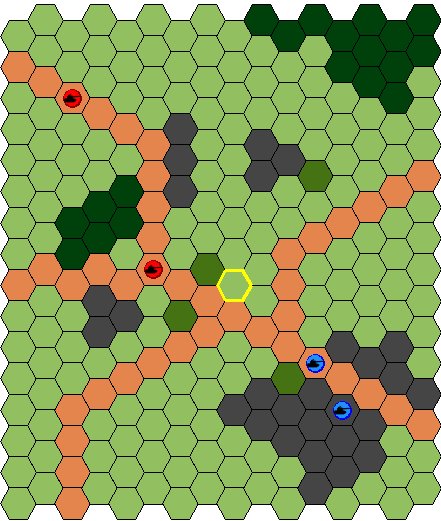

In [30]:
drawState(board, state)

The image also confirms the equality of the state.

We can now try to build the `Attack` action of before.

In [31]:
atk = gm.actionAttackFigure(board, state, r2, b1, r1.weapons['CA'])

No error means success! We can execute the action.

In [32]:
gm.step(board, state, atk)

ATK=8 TER=0 DEF=0 STAT=0 END=0 INT=0 [10]/8 False [0] 

It is also possible to draw actions on the map: when an action is executed and the state updated, the state keep this action in the `state.lastAction` field.

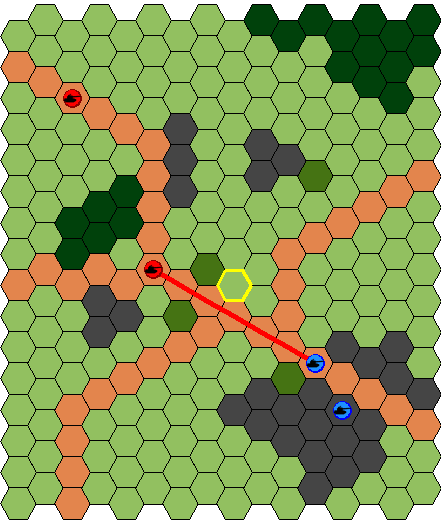

In [33]:
drawState(board, state, True)

If we want to try a response, we first need to move `b1`:

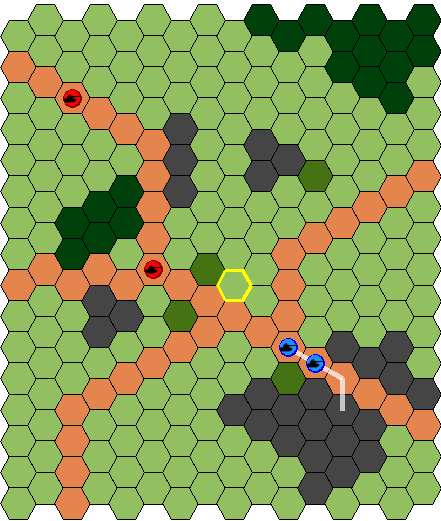

In [34]:
m = gm.actionMove(board, state, b2, destination=Hex(10,10).cube())
gm.step(board, state, m)

drawState(board, state, True)

In this situation, `r2` can respond to the last action of `b2`.

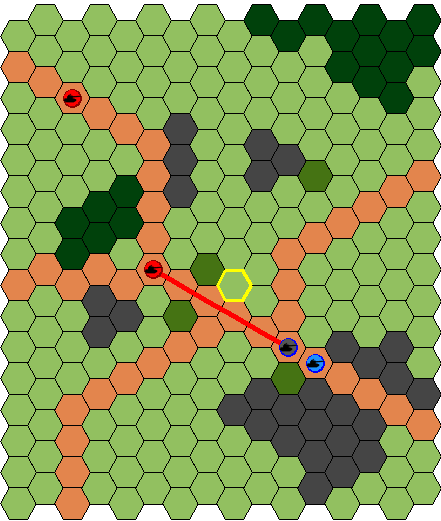

In [35]:
res = gm.actionRespond(board, state, r2, b2, r1.weapons['CA'])
gm.step(board, state, res)

drawState(board, state, True)

# Agents

We create two agents: one for **red** and one for **blue**.

In [36]:
from agents import GreedyAgent

In [37]:
red = GreedyAgent(RED, 42)
blue = GreedyAgent(BLUE, 24)

In order to play with the agents, we need to use the `MatchManager`object. We will recycle the `state` and `board` above.

In [38]:
from agents import MatchManager

In [39]:
board, state = buildScenario('Test2v2')

In [40]:
mm = MatchManager('', red, blue, board, state, 2)

Since the `MatchManager` outputs a lot of information, it is useful to enable the logs.

In [41]:
from utils.setup_logging import setup_logging
setup_logging()

With this object we can advance step by step in a match.

2021-07-16 14:29:53 agents.matchmanager INFO           2 SCENARIO: battleground16x16
2021-07-16 14:29:53 agents.matchmanager INFO           2 SEED:     2
2021-07-16 14:29:53 agents.matchmanager INFO           2 ==================================================
2021-07-16 14:29:53 agents.matchmanager INFO           2 Turn 0


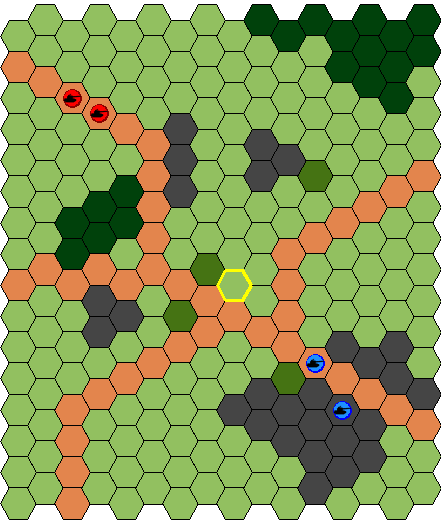

In [42]:
mm.nextStep()
drawState(mm.board, mm.state, True)

2021-07-16 14:29:54 agents.matchmanager INFO           2 red   action   : RED  : Tank1     : Moved to (6, 8) 


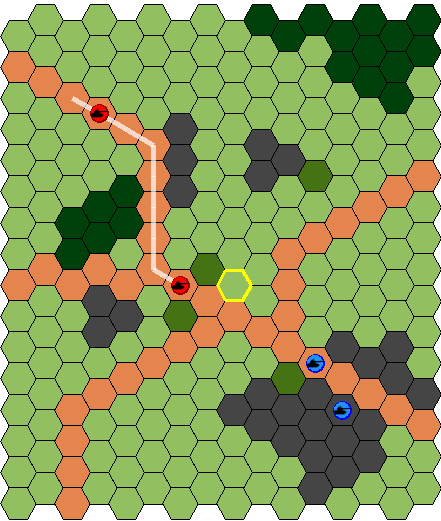

In [43]:
mm.nextStep()
drawState(mm.board, mm.state, True)

2021-07-16 14:29:54 agents.matchmanager INFO           2 blue  response : BLUE :           : No response 


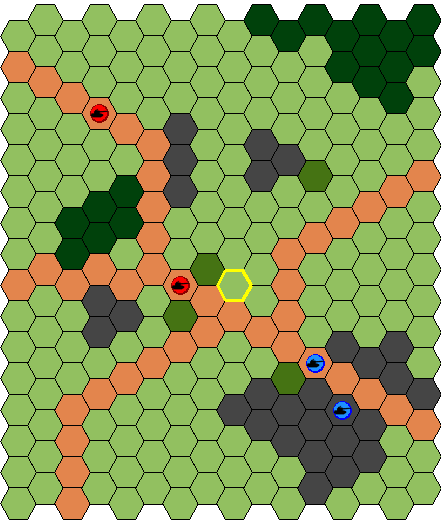

In [44]:
mm.nextStep()
drawState(mm.board, mm.state)

2021-07-16 14:29:54 agents.matchmanager INFO           2 blue  action   : BLUE : Tank4     : Moved to (8, 8) 


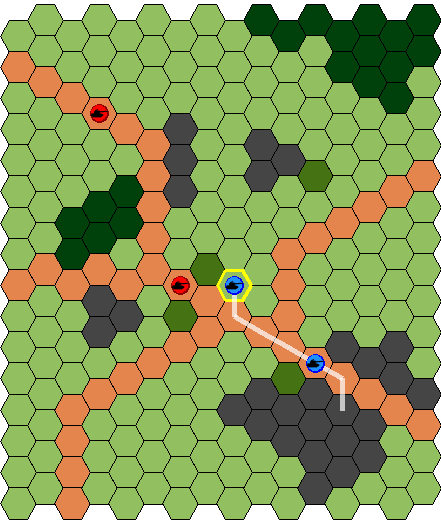

In [45]:
mm.nextStep()
drawState(mm.board, mm.state, True)

We can highlight a unit using drawing functions.

Or let the match play itself.

In [46]:
mm.reset()
mm.play()

2021-07-16 14:29:55 agents.matchmanager INFO           2 SCENARIO: battleground16x16
2021-07-16 14:29:55 agents.matchmanager INFO           2 SEED:     2
2021-07-16 14:29:55 agents.matchmanager INFO           2 ==================================================
2021-07-16 14:29:55 agents.matchmanager INFO           2 Turn 0
2021-07-16 14:29:55 agents.matchmanager INFO           2 red   action   : RED  : Tank1     : Moved to (6, 8) 
2021-07-16 14:29:55 agents.matchmanager INFO           2 blue  response : BLUE :           : No response 
2021-07-16 14:29:55 agents.matchmanager INFO           2 blue  action   : BLUE : Tank4     : Moved to (8, 8) 
2021-07-16 14:29:55 agents.matchmanager INFO           2 red   response : RED  :           : No response 
2021-07-16 14:29:55 agents.matchmanager INFO           2 red   action   : RED  : Tank2     : Moved to (8, 7) 
2021-07-16 14:29:55 agents.matchmanager INFO           2 blue  response : BLUE :           : No response 
2021-07-16 14:29:56 agents